In [ ]:
## Human Activity Recognition (HAR) — Advanced ML + Deep Learning
**Goal:** Multi-class activity classification from wearable sensor time-series  

Notebook Sections:
1. Setup & Imports
2. Dataset Paths & Discovery (subject*.dat)
3. Data Loading & Cleaning
4. Exploratory Data Analysis (EDA)
5. Subject-wise Train / Validation / Test Split
6. Time-Series Windowing & Label Voting
7. Feature Normalization (Train-only)
8. Baseline Machine Learning Model (LightGBM with Engineered Features)
9. Deep Learning Model (CNN on Raw Windows)
10. Hybrid Model (CNN Feature Extraction → LightGBM)
11. Model Evaluation & Performance Metrics
12. Training Curves & Error Analysis
13. Final Model Comparison & Visualization


In [ ]:
#Install & Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

sns.set_style("whitegrid")
np.random.seed(42)


In [ ]:
#Set Project Paths + Locate Dataset

In [3]:
from pathlib import Path

# ✅ CHANGE THIS to your project folder
PROJECT_ROOT = Path(r"D:\HAR_PROJECT")
DATA_DIR = PROJECT_ROOT / "data"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("Exists?", DATA_DIR.exists())

# Find subject files
dat_files = sorted(DATA_DIR.glob("subject*.dat"))
print("Number of subject .dat files:", len(dat_files))
dat_files[:5]


PROJECT_ROOT: D:\HAR_PROJECT
DATA_DIR: D:\HAR_PROJECT\data
Exists? True
Number of subject .dat files: 9


[WindowsPath('D:/HAR_PROJECT/data/subject101.dat'),
 WindowsPath('D:/HAR_PROJECT/data/subject102.dat'),
 WindowsPath('D:/HAR_PROJECT/data/subject103.dat'),
 WindowsPath('D:/HAR_PROJECT/data/subject104.dat'),
 WindowsPath('D:/HAR_PROJECT/data/subject105.dat')]

In [ ]:
#Define Columns + Activity Map

In [5]:
# ---------- Column names (PAMAP2-style) ----------

PAMAP2_COLS_54 = [
    "timestamp", "activity_id", "heart_rate",
    # IMU hand
    "hand_temp",
    "hand_acc1_x","hand_acc1_y","hand_acc1_z",
    "hand_acc2_x","hand_acc2_y","hand_acc2_z",
    "hand_gyro_x","hand_gyro_y","hand_gyro_z",
    "hand_mag_x","hand_mag_y","hand_mag_z",
    "hand_orient_1","hand_orient_2","hand_orient_3","hand_orient_4",
    # IMU chest
    "chest_temp",
    "chest_acc1_x","chest_acc1_y","chest_acc1_z",
    "chest_acc2_x","chest_acc2_y","chest_acc2_z",
    "chest_gyro_x","chest_gyro_y","chest_gyro_z",
    "chest_mag_x","chest_mag_y","chest_mag_z",
    "chest_orient_1","chest_orient_2","chest_orient_3","chest_orient_4",
    # IMU ankle
    "ankle_temp",
    "ankle_acc1_x","ankle_acc1_y","ankle_acc1_z",
    "ankle_acc2_x","ankle_acc2_y","ankle_acc2_z",
    "ankle_gyro_x","ankle_gyro_y","ankle_gyro_z",
    "ankle_mag_x","ankle_mag_y","ankle_mag_z",
    "ankle_orient_1","ankle_orient_2","ankle_orient_3","ankle_orient_4",
]

# ---------- Activity mapping ----------


ACTIVITY_MAP = {
    1: "Lying",
    2: "Sitting",
    3: "Standing",
    4: "Walking",
    5: "Running",
    6: "Cycling",
    7: "Nordic walking",
    12: "Ascending stairs",
    13: "Descending stairs",
    16: "Vacuum cleaning",
    17: "Ironing",
    24: "Rope jumping",
}


In [ ]:
#Loader Function (reads each subject)

In [6]:
def load_subject_dat(filepath: Path) -> pd.DataFrame:
    """
    Loads one subject*.dat file.
    Auto-handles column count differences safely.
    """
    # PAMAP2 files are space-separated; multiple spaces -> use delim_whitespace
    df = pd.read_csv(filepath, delim_whitespace=True, header=None)
    
    # Assign columns if match
    if df.shape[1] == len(PAMAP2_COLS_54):
        df.columns = PAMAP2_COLS_54
    else:
        # fallback: generic columns
        df.columns = [f"col_{i}" for i in range(df.shape[1])]
        # try to rename first 3 if possible
        if df.shape[1] >= 3:
            df = df.rename(columns={"col_0":"timestamp", "col_1":"activity_id", "col_2":"heart_rate"})
    
    # subject id from filename: subject101.dat -> 101
    sid = int("".join([c for c in filepath.stem if c.isdigit()]))
    df["subject_id"] = sid
    return df


In [ ]:
#Load All + Clean (drop transient + label mapping)

In [7]:
dfs = [load_subject_dat(f) for f in dat_files]
data = pd.concat(dfs, ignore_index=True)

print("Raw combined shape:", data.shape)
print("Subjects:", sorted(data["subject_id"].unique()))

# Remove transient class (activity_id == 0)
if "activity_id" in data.columns:
    before = data.shape[0]
    data = data[data["activity_id"] != 0].copy()
    print("Removed transient rows:", before - data.shape[0])

# Map activity names (if unknown IDs exist, keep as "ID_xx")
if "activity_id" in data.columns:
    all_ids = sorted(data["activity_id"].dropna().unique())
    auto_map = {aid: ACTIVITY_MAP.get(aid, f"ID_{aid}") for aid in all_ids}
    data["activity"] = data["activity_id"].map(auto_map)

print("Cleaned shape:", data.shape)
print("Num activities:", data["activity"].nunique())
data[["timestamp","activity_id","activity","subject_id"]].head()


C:\Users\souga\AppData\Local\Temp\ipykernel_30388\705268509.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, header=None)
C:\Users\souga\AppData\Local\Temp\ipykernel_30388\705268509.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, header=None)
C:\Users\souga\AppData\Local\Temp\ipykernel_30388\705268509.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, header=None)
C:\Users\souga\AppData\Local\Temp\ipykernel_30388\705268509.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version.

Raw combined shape: (2872533, 55)
Subjects: [np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(107), np.int64(108), np.int64(109)]
Removed transient rows: 929661
Cleaned shape: (1942872, 56)
Num activities: 12


timestamp  activity_id activity  subject_id
2928      37.66            1    Lying         101
2929      37.67            1    Lying         101
2930      37.68            1    Lying         101
2931      37.69            1    Lying         101
2932      37.70            1    Lying         101

In [ ]:
#Quick checks (missing values + class distribution)

In [8]:
print("Missing values (top 15):")
print(data.isna().sum().sort_values(ascending=False).head(15))

print("\nActivity counts:")
display(data["activity"].value_counts().head(30))


Missing values (top 15):
heart_rate       1765464
hand_temp          11124
hand_acc1_y        11124
hand_acc1_x        11124
hand_acc1_z        11124
hand_acc2_x        11124
hand_acc2_z        11124
hand_acc2_y        11124
hand_orient_1      11124
hand_orient_2      11124
hand_gyro_x        11124
hand_gyro_y        11124
hand_gyro_z        11124
hand_mag_x         11124
hand_mag_y         11124
dtype: int64

Activity counts:


activity
Walking              238761
Ironing              238690
Lying                192523
Standing             189931
Nordic walking       188107
Sitting              185188
Vacuum cleaning      175353
Cycling              164600
Ascending stairs     117216
Descending stairs    104944
Running               98199
Rope jumping          49360
Name: count, dtype: int64

In [ ]:
#Activity Distribution

C:\Users\souga\AppData\Local\Temp\ipykernel_30388\232222159.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


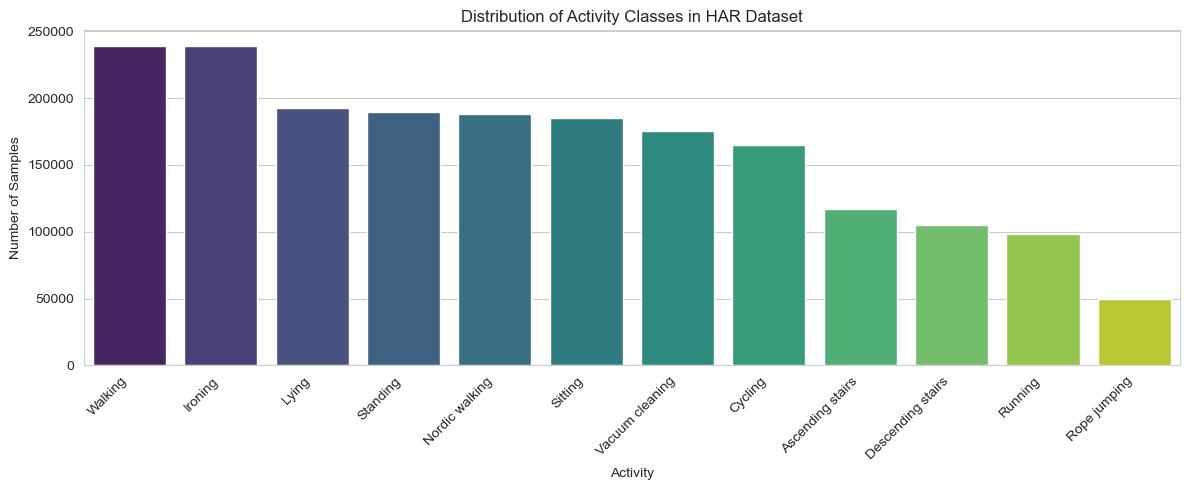

In [11]:
plt.figure(figsize=(12,5))

activity_counts = data["activity"].value_counts()

sns.barplot(
    x=activity_counts.index,
    y=activity_counts.values,
    palette="viridis"
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Samples")
plt.xlabel("Activity")
plt.title("Distribution of Activity Classes in HAR Dataset")
plt.tight_layout()
plt.show()


In [ ]:
#EDA

In [ ]:
#Select representative sensor channels

In [12]:
# Choose representative sensor channels
ACC_CHANNELS = [
    "hand_acc1_x", "hand_acc1_y", "hand_acc1_z",
    "chest_acc1_x", "chest_acc1_y", "chest_acc1_z",
    "ankle_acc1_x", "ankle_acc1_y", "ankle_acc1_z",
]

# Filter only columns that exist (safety)
ACC_CHANNELS = [c for c in ACC_CHANNELS if c in data.columns]
ACC_CHANNELS


['hand_acc1_x',
 'hand_acc1_y',
 'hand_acc1_z',
 'chest_acc1_x',
 'chest_acc1_y',
 'chest_acc1_z',
 'ankle_acc1_x',
 'ankle_acc1_y',
 'ankle_acc1_z']

In [ ]:
#Plot sensor signals for different activities

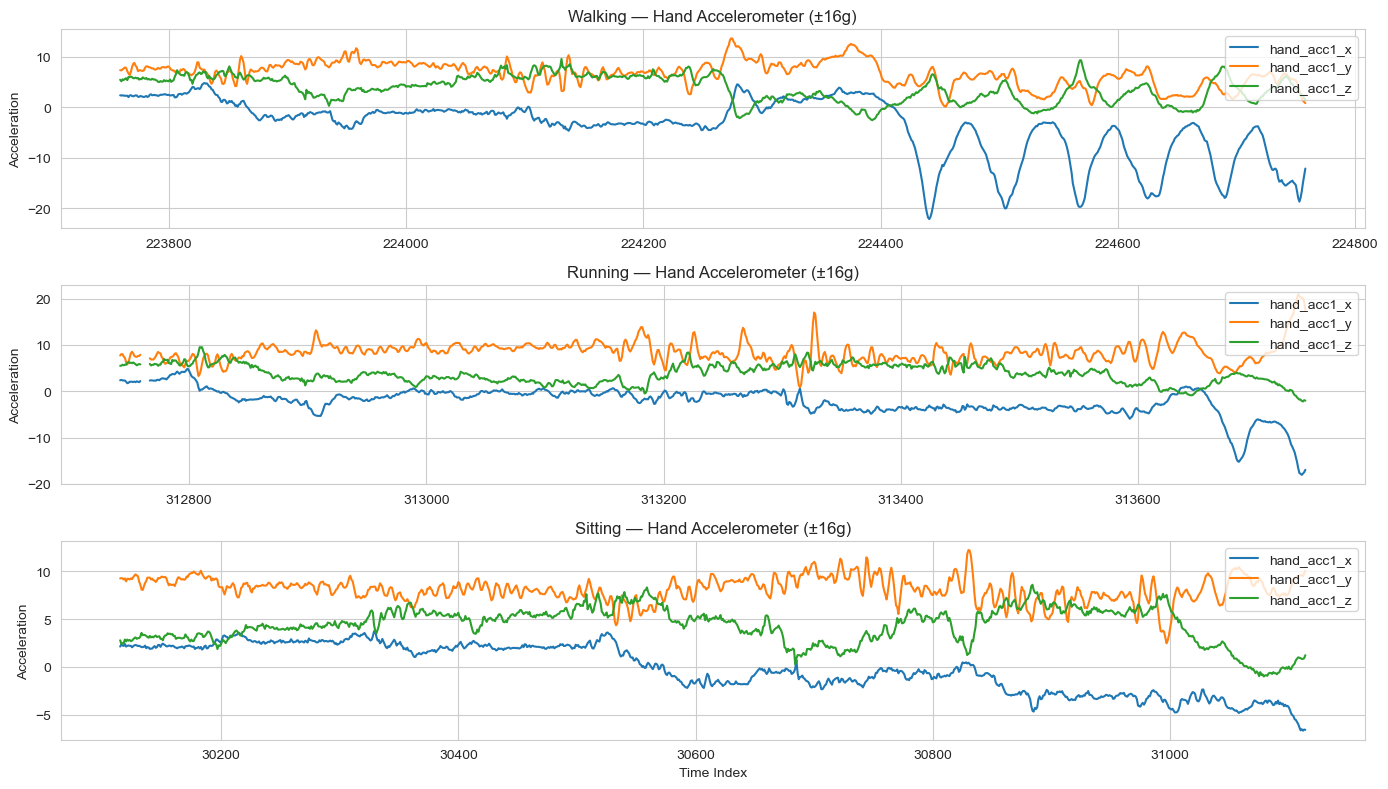

In [13]:
sample_activities = ["Walking", "Running", "Sitting"]

plt.figure(figsize=(14,8))

for i, act in enumerate(sample_activities):
    act_df = data[data["activity"] == act]
    act_df = act_df.iloc[:1000]  # small slice for visualization
    
    plt.subplot(len(sample_activities), 1, i+1)
    plt.plot(act_df[ACC_CHANNELS[0]], label=ACC_CHANNELS[0])
    plt.plot(act_df[ACC_CHANNELS[1]], label=ACC_CHANNELS[1])
    plt.plot(act_df[ACC_CHANNELS[2]], label=ACC_CHANNELS[2])
    
    plt.title(f"{act} — Hand Accelerometer (±16g)")
    plt.ylabel("Acceleration")
    plt.legend(loc="upper right")

plt.xlabel("Time Index")
plt.tight_layout()
plt.show()


In [ ]:
#Heart Rate vs Activity

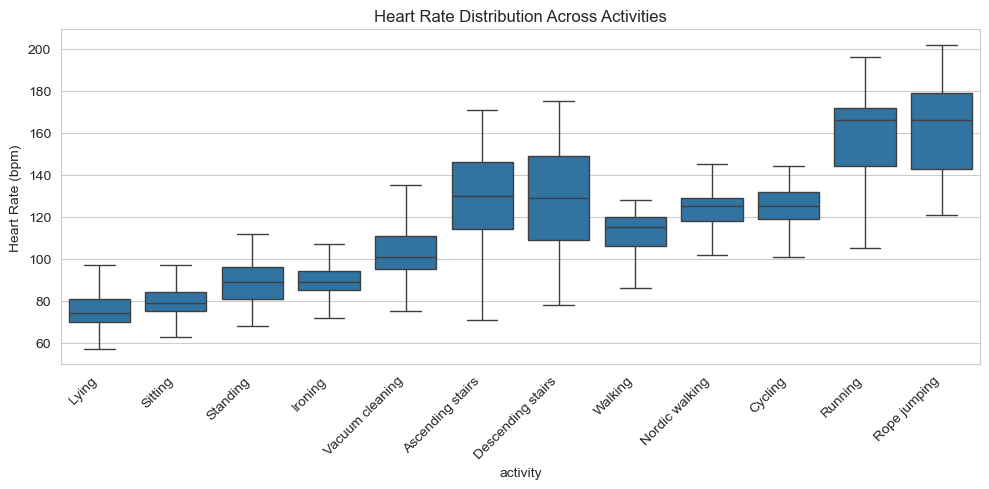

In [14]:
if "heart_rate" in data.columns:
    plt.figure(figsize=(10,5))
    
    sns.boxplot(
        x="activity",
        y="heart_rate",
        data=data,
        showfliers=False
    )
    
    plt.xticks(rotation=45, ha="right")
    plt.title("Heart Rate Distribution Across Activities")
    plt.ylabel("Heart Rate (bpm)")
    plt.tight_layout()
    plt.show()


In [ ]:
#Same Activity, Different Subjects

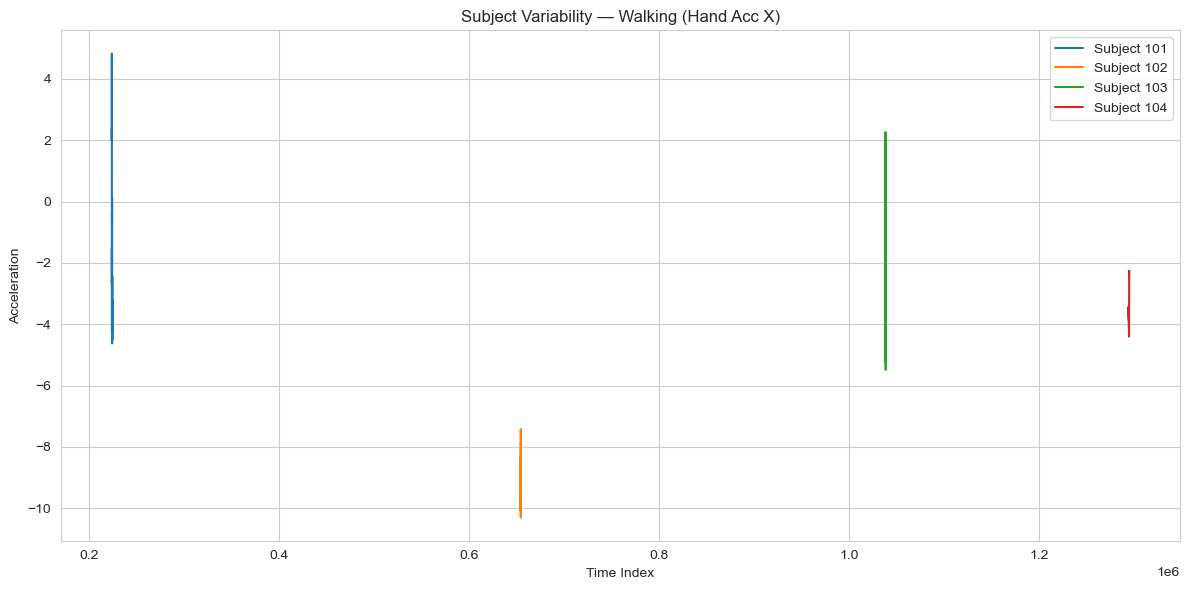

In [15]:
activity_to_check = "Walking"

plt.figure(figsize=(12,6))

for sid in sorted(data["subject_id"].unique())[:4]:
    sub_df = data[
        (data["activity"] == activity_to_check) &
        (data["subject_id"] == sid)
    ].iloc[:500]
    
    plt.plot(sub_df[ACC_CHANNELS[0]], label=f"Subject {sid}")

plt.title(f"Subject Variability — {activity_to_check} (Hand Acc X)")
plt.xlabel("Time Index")
plt.ylabel("Acceleration")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Correlation Analysis (Feature Redundancy)

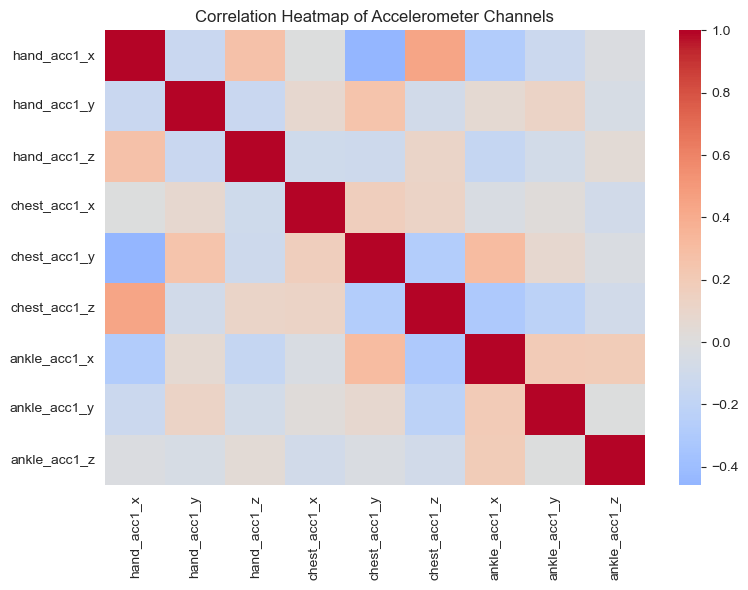

In [16]:
# Use a small subset for speed
corr_df = data[ACC_CHANNELS].dropna().sample(3000, random_state=42)

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_df.corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap of Accelerometer Channels")
plt.tight_layout()
plt.show()


In [ ]:
#Missing Value Analysis

In [ ]:
#Missing Value Summary

In [17]:
missing_summary = (
    data.isna()
    .sum()
    .sort_values(ascending=False)
)

missing_summary.head(15)


heart_rate       1765464
hand_temp          11124
hand_acc1_y        11124
hand_acc1_x        11124
hand_acc1_z        11124
hand_acc2_x        11124
hand_acc2_z        11124
hand_acc2_y        11124
hand_orient_1      11124
hand_orient_2      11124
hand_gyro_x        11124
hand_gyro_y        11124
hand_gyro_z        11124
hand_mag_x         11124
hand_mag_y         11124
dtype: int64

In [ ]:
#Heart Rate Interpolation (Physiological Signal Handling)

In [ ]:
#Subject-wise Heart Rate Interpolation

In [18]:
if "heart_rate" in data.columns:
    data["heart_rate"] = (
        data
        .groupby("subject_id")["heart_rate"]
        .apply(lambda x: x.interpolate(method="linear", limit_direction="both"))
        .reset_index(level=0, drop=True)
    )

print("Remaining HR NaNs:", data["heart_rate"].isna().sum())


Remaining HR NaNs: 0


In [ ]:
#Sensor Missing Values

In [19]:
sensor_cols = [
    c for c in data.columns
    if c not in ["timestamp", "activity", "activity_id", "subject_id"]
]

data[sensor_cols] = (
    data
    .groupby("subject_id")[sensor_cols]
    .apply(lambda df: df.ffill().bfill())
    .reset_index(level=0, drop=True)
)

print("Remaining NaNs after sensor fill:", data.isna().sum().sum())


Remaining NaNs after sensor fill: 0


In [ ]:
#Label Encoding

In [20]:
le = LabelEncoder()
data["activity_label"] = le.fit_transform(data["activity"])

print("Encoded classes:")
for i, cls in enumerate(le.classes_):
    print(i, "→", cls)


Encoded classes:
0 → Ascending stairs
1 → Cycling
2 → Descending stairs
3 → Ironing
4 → Lying
5 → Nordic walking
6 → Rope jumping
7 → Running
8 → Sitting
9 → Standing
10 → Vacuum cleaning
11 → Walking


In [ ]:
#Feature Set Definition

In [21]:
# Drop orientation channels explicitly
orientation_cols = [c for c in data.columns if "orient" in c.lower()]
data = data.drop(columns=orientation_cols)

print("Dropped orientation columns:", len(orientation_cols))

# Final feature columns (raw signals)
FEATURE_COLS = [
    c for c in data.columns
    if c not in ["timestamp", "activity", "activity_id", "activity_label", "subject_id"]
]

len(FEATURE_COLS), FEATURE_COLS[:10]


Dropped orientation columns: 12


(40,
 ['heart_rate',
  'hand_temp',
  'hand_acc1_x',
  'hand_acc1_y',
  'hand_acc1_z',
  'hand_acc2_x',
  'hand_acc2_y',
  'hand_acc2_z',
  'hand_gyro_x',
  'hand_gyro_y'])

In [ ]:
#Final Sanity Checks (Leakage Prevention)

In [22]:
assert data.isna().sum().sum() == 0, "❌ NaNs still exist!"
assert data["subject_id"].nunique() >= 2, "❌ Subject info corrupted!"
assert data["activity_label"].nunique() >= 2, "❌ Labels corrupted!"

print("✅ Data preprocessing checks passed")


✅ Data preprocessing checks passed


In [ ]:
#Sliding Window Segmentation (Time-Series Core)

In [ ]:
#Train / Validation / Test Subject Split (STRICT)

In [ ]:
#Subject-wise split

In [23]:
# Subjects present
subjects = sorted(data["subject_id"].unique())
subjects


[np.int64(101),
 np.int64(102),
 np.int64(103),
 np.int64(104),
 np.int64(105),
 np.int64(106),
 np.int64(107),
 np.int64(108),
 np.int64(109)]

In [24]:
# Manual subject-wise split (examiner-friendly)
# Adjust if your dataset has different subjects

train_subjects = subjects[:int(0.6 * len(subjects))]
val_subjects   = subjects[int(0.6 * len(subjects)):int(0.8 * len(subjects))]
test_subjects  = subjects[int(0.8 * len(subjects)):]

print("Train subjects:", train_subjects)
print("Val subjects  :", val_subjects)
print("Test subjects :", test_subjects)


Train subjects: [np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105)]
Val subjects  : [np.int64(106), np.int64(107)]
Test subjects : [np.int64(108), np.int64(109)]


In [ ]:
#Create split datasets

In [25]:
train_df = data[data["subject_id"].isin(train_subjects)].copy()
val_df   = data[data["subject_id"].isin(val_subjects)].copy()
test_df  = data[data["subject_id"].isin(test_subjects)].copy()

print("Train shape:", train_df.shape)
print("Val shape  :", val_df.shape)
print("Test shape :", test_df.shape)


Train shape: (1191507, 45)
Val shape  : (482872, 45)
Test shape : (268493, 45)


In [ ]:
#Windowing Function (Reusable & Clean)

In [ ]:
#Window Generator

In [26]:
def create_windows(df, feature_cols, label_col,
                   window_size=256, overlap=0.5):
    """
    Create sliding windows from a dataframe.
    Returns X (windows), y (labels).
    """
    step = int(window_size * (1 - overlap))
    
    X, y = [], []
    
    for sid in df["subject_id"].unique():
        sub_df = df[df["subject_id"] == sid]
        
        X_sub = sub_df[feature_cols].values
        y_sub = sub_df[label_col].values
        
        for start in range(0, len(sub_df) - window_size, step):
            end = start + window_size
            
            window_x = X_sub[start:end]
            window_y = y_sub[start:end]
            
            # Majority vote
            label = np.bincount(window_y).argmax()
            
            X.append(window_x)
            y.append(label)
    
    return np.array(X), np.array(y)


In [ ]:
#Create Train / Val / Test Windows

In [27]:
WINDOW_SIZE = 256
OVERLAP = 0.5

X_train, y_train = create_windows(
    train_df, FEATURE_COLS, "activity_label",
    window_size=WINDOW_SIZE, overlap=OVERLAP
)

X_val, y_val = create_windows(
    val_df, FEATURE_COLS, "activity_label",
    window_size=WINDOW_SIZE, overlap=OVERLAP
)

X_test, y_test = create_windows(
    test_df, FEATURE_COLS, "activity_label",
    window_size=WINDOW_SIZE, overlap=OVERLAP
)


In [ ]:
#Inspect shapes

In [28]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("X_val  :", X_val.shape)
print("y_val  :", y_val.shape)

print("X_test :", X_test.shape)
print("y_test :", y_test.shape)


X_train: (9301, 256, 40)
y_train: (9301,)
X_val  : (3769, 256, 40)
y_val  : (3769,)
X_test : (2094, 256, 40)
y_test : (2094,)


In [ ]:
#Class Distribution After Windowing (Graph)

In [ ]:
#Window-Level Distribution

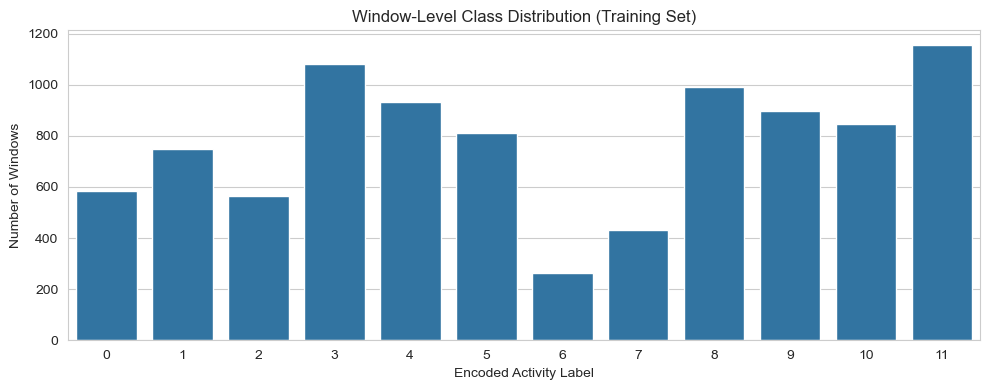

In [29]:
plt.figure(figsize=(10,4))
sns.countplot(x=y_train)
plt.title("Window-Level Class Distribution (Training Set)")
plt.xlabel("Encoded Activity Label")
plt.ylabel("Number of Windows")
plt.tight_layout()
plt.show()


In [ ]:
#Leakage Check

In [30]:
assert set(train_subjects).isdisjoint(test_subjects)
assert set(train_subjects).isdisjoint(val_subjects)
assert set(val_subjects).isdisjoint(test_subjects)

print("✅ Subject-wise separation verified (no leakage)")


✅ Subject-wise separation verified (no leakage)


In [ ]:
#Normalization, Data Augmentation & Model-Ready

In [ ]:
#Normalization

In [ ]:
#Fit scaler on TRAIN ONLY (window-level)

In [31]:
# Flatten windows for scaler fitting
num_features = X_train.shape[2]

scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, num_features)
scaler.fit(X_train_reshaped)

# Apply to train / val / test
def normalize_windows(X, scaler):
    X_flat = X.reshape(-1, X.shape[2])
    X_norm = scaler.transform(X_flat)
    return X_norm.reshape(X.shape)

X_train_norm = normalize_windows(X_train, scaler)
X_val_norm   = normalize_windows(X_val, scaler)
X_test_norm  = normalize_windows(X_test, scaler)

print("✅ Normalization complete")


✅ Normalization complete


In [ ]:
#Sanity check

In [32]:
print("Train mean (≈0):", X_train_norm.mean())
print("Train std  (≈1):", X_train_norm.std())

Train mean (≈0): -3.4501108859173524e-14
Train std  (≈1): 0.9999999999994846


In [ ]:
#Data Augmentation

In [ ]:
#Define augmentation functions

In [33]:
def add_gaussian_noise(X, std=0.01):
    noise = np.random.normal(0, std, X.shape)
    return X + noise

def magnitude_scaling(X, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return X * scale


In [ ]:
#Apply augmentation to training set

In [34]:
X_train_aug = np.concatenate([
    X_train_norm,
    add_gaussian_noise(X_train_norm),
    magnitude_scaling(X_train_norm)
])

y_train_aug = np.concatenate([
    y_train,
    y_train,
    y_train
])

print("Original train windows:", X_train_norm.shape[0])
print("Augmented train windows:", X_train_aug.shape[0])


Original train windows: 9301
Augmented train windows: 27903


In [ ]:
#Prepare Inputs for Machine Learning Baseline

In [ ]:
#Feature extraction function

In [37]:
def extract_stat_features(X):
    """
    Extract statistical features from windowed data.
    Input: (samples, time, features)
    Output: (samples, features*6)
    """
    features = []
    
    for win in X:
        feat = []
        feat.extend(win.mean(axis=0))
        feat.extend(win.std(axis=0))
        feat.extend(win.min(axis=0))
        feat.extend(win.max(axis=0))
        feat.extend(np.median(win, axis=0))
        feat.extend(np.ptp(win, axis=0))  # peak-to-peak
        features.append(feat)
        
    return np.array(features)


In [ ]:
#Extract ML features

In [38]:
X_train_ml = extract_stat_features(X_train_norm)
X_val_ml   = extract_stat_features(X_val_norm)
X_test_ml  = extract_stat_features(X_test_norm)

print("ML feature shape:", X_train_ml.shape)


ML feature shape: (9301, 240)


In [ ]:
#Class Weights (For Imbalance Handling)

In [39]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict


{0: np.float64(1.3294739851343624),
 1: np.float64(1.0362076648841354),
 2: np.float64(1.3694051825677267),
 3: np.float64(0.7163431916204559),
 4: np.float64(0.831634477825465),
 5: np.float64(0.9568930041152264),
 6: np.float64(2.9583333333333335),
 7: np.float64(1.798337200309358),
 8: np.float64(0.7829124579124579),
 9: np.float64(0.8650483630952381),
 10: np.float64(0.9161741528762806),
 11: np.float64(0.671067821067821)}

In [ ]:
#Baseline Machine Learning (LightGBM)

In [ ]:
#Imports

In [64]:
import numpy as np
import pandas as pd

from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, record_evaluation

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from scipy.fftpack import fft


In [65]:
# All sensor columns (exclude labels, subject, timestamp)
feature_cols = [
    c for c in train_df.columns
    if c not in ["timestamp", "activity", "activity_id", "subject_id"]
]

print("Number of raw features:", len(feature_cols))


Number of raw features: 41


In [ ]:
#WINDOWING (TEMPORAL MODELING)

In [66]:
WINDOW_SIZE = 256
STEP_SIZE   = 64


In [67]:
X_train, y_train = create_windows(
    train_df, feature_cols, "activity", WINDOW_SIZE, STEP_SIZE
)

X_val, y_val = create_windows(
    val_df, feature_cols, "activity", WINDOW_SIZE, STEP_SIZE
)

X_test, y_test = create_windows(
    test_df, feature_cols, "activity", WINDOW_SIZE, STEP_SIZE
)

print("Window shapes:")
print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Window shapes:
Train: (18361, 256, 41)
Val  : (7438, 256, 41)
Test : (4136, 256, 41)


In [ ]:
#FEATURE EXTRACTION

In [68]:
import numpy as np
from scipy.stats import skew, kurtosis

def extract_features(X):
    feats = []

    for w in X:
        f = []

        # Time-domain
        f.extend(np.mean(w, axis=0))
        f.extend(np.std(w, axis=0))
        f.extend(np.min(w, axis=0))
        f.extend(np.max(w, axis=0))
        f.extend(skew(w, axis=0))
        f.extend(kurtosis(w, axis=0))

        # Frequency-domain
        fft_vals = np.abs(np.fft.rfft(w, axis=0))
        f.extend(np.mean(fft_vals, axis=0))
        f.extend(np.std(fft_vals, axis=0))

        feats.append(f)

    return np.array(feats)


In [ ]:
#Apply feature extraction

In [69]:
X_train_feat = extract_features(X_train)
X_val_feat   = extract_features(X_val)
X_test_feat  = extract_features(X_test)

print(X_train_feat.shape, X_val_feat.shape, X_test_feat.shape)


C:\Users\souga\AppData\Local\Temp\ipykernel_30388\2657124984.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f.extend(skew(w, axis=0))
C:\Users\souga\AppData\Local\Temp\ipykernel_30388\2657124984.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f.extend(kurtosis(w, axis=0))


(18361, 328) (7438, 328) (4136, 328)


In [ ]:
#LABEL ENCODING

In [70]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

print("Classes:", le.classes_)


Classes: ['Ascending stairs' 'Cycling' 'Descending stairs' 'Ironing' 'Lying'
 'Nordic walking' 'Rope jumping' 'Running' 'Sitting' 'Standing'
 'Vacuum cleaning' 'Walking']


In [ ]:
#NORMALIZATION

In [ ]:
#Detect NaN / Inf

In [72]:
import numpy as np

print("NaNs in train:", np.isnan(X_train_feat).sum())
print("Infs in train:", np.isinf(X_train_feat).sum())


NaNs in train: 122682
Infs in train: 0


In [ ]:
#SAFE FEATURE CLEANING

In [73]:
# Replace NaN and Inf safely
X_train_feat = np.nan_to_num(X_train_feat, nan=0.0, posinf=0.0, neginf=0.0)
X_val_feat   = np.nan_to_num(X_val_feat,   nan=0.0, posinf=0.0, neginf=0.0)
X_test_feat  = np.nan_to_num(X_test_feat,  nan=0.0, posinf=0.0, neginf=0.0)


In [ ]:
#Variance-based Feature Cleanup

In [74]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=1e-6)

X_train_feat = vt.fit_transform(X_train_feat)
X_val_feat   = vt.transform(X_val_feat)
X_test_feat  = vt.transform(X_test_feat)

print("Features after variance filtering:", X_train_feat.shape[1])


Features after variance filtering: 325


In [ ]:
#Normalization

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_ml = scaler.fit_transform(X_train_feat)
X_val_ml   = scaler.transform(X_val_feat)
X_test_ml  = scaler.transform(X_test_feat)


In [ ]:
#CLASS WEIGHTS

In [77]:
from collections import Counter
import numpy as np

counts = Counter(y_train_enc)
total = sum(counts.values())

class_weight = {
    cls: total / (len(counts) * cnt)
    for cls, cnt in counts.items()
}

class_weight


{np.int64(4): 0.8275193798449613,
 np.int64(8): 0.7794617082696553,
 np.int64(9): 0.863965744400527,
 np.int64(3): 0.7129931655793724,
 np.int64(10): 0.9140282755874154,
 np.int64(0): 1.360074074074074,
 np.int64(2): 1.4076203618521925,
 np.int64(11): 0.667867015859159,
 np.int64(5): 0.9533229491173416,
 np.int64(1): 1.0317487075747358,
 np.int64(7): 1.8000980392156862,
 np.int64(6): 2.9595422308188266}

In [ ]:
# LIGHTGBM

In [78]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(le.classes_),
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=128,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight=class_weight,
    random_state=42,
    n_jobs=-1
)


In [79]:
lgb_model.fit(
    X_train_ml,
    y_train_enc,
    eval_set=[(X_val_ml, y_val_enc)],
    eval_metric="multi_logloss"
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79893
[LightGBM] [Info] Number of data points in the train set: 18361, number of used features: 325
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(class_weight={np.int64(0): 1.360074074074074,
                             np.int64(1): 1.0317487075747358,
                             np.int64(2): 1.4076203618521925,
                             np.int64(3): 0.7129931655793724,
                             np.int64(4): 0.8275193798449613,
                             np.int64(5): 0.9533229491173416,
                             np.int64(6): 2.9595422308188266,
                             np.int64(7): 1.8000980392156862,
                             np.int64(8): 0.7794617082696553,
                             np.int64(9): 0.863965744400527,
                             np.int64(10): 0.9140282755874154,
                             np.int64(11): 0.667867015859159},
               colsample_bytree=0.9, learning_rate=0.03, n_estimators=1200,
               n_jobs=-1, num_class=12, num_leaves=128, objective='multiclass',
               random_state=42, subsample=0.9)

In [80]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred = lgb_model.predict(X_test_ml)

acc = accuracy_score(y_test_enc, y_pred)
f1  = f1_score(y_test_enc, y_pred, average="macro")

print("LightGBM Test Accuracy:", acc)
print("LightGBM Macro F1     :", f1)

print("\nClassification Report:\n")
print(classification_report(
    y_test_enc,
    y_pred,
    target_names=le.classes_
))


C:\Users\souga\anaconda3\envs\har-ml-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Test Accuracy: 0.9941972920696325
LightGBM Macro F1     : 0.9920588952131922

Classification Report:

                   precision    recall  f1-score   support

 Ascending stairs       1.00      1.00      1.00       176
          Cycling       1.00      1.00      1.00       394
Descending stairs       1.00      1.00      1.00       142
          Ironing       1.00      1.00      1.00       512
            Lying       1.00      1.00      1.00       374
   Nordic walking       0.99      1.00      0.99       447
     Rope jumping       0.94      0.96      0.95       230
          Running       0.98      0.94      0.96       254
          Sitting       1.00      1.00      1.00       354
         Standing       1.00      1.00      1.00       389
  Vacuum cleaning       1.00      1.00      1.00       375
          Walking       1.00      1.00      1.00       489

         accuracy                           0.99      4136
        macro avg       0.99      0.99      0.99      4136
  

In [ ]:
#Confusion Matrix

C:\Users\souga\anaconda3\envs\har-ml-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


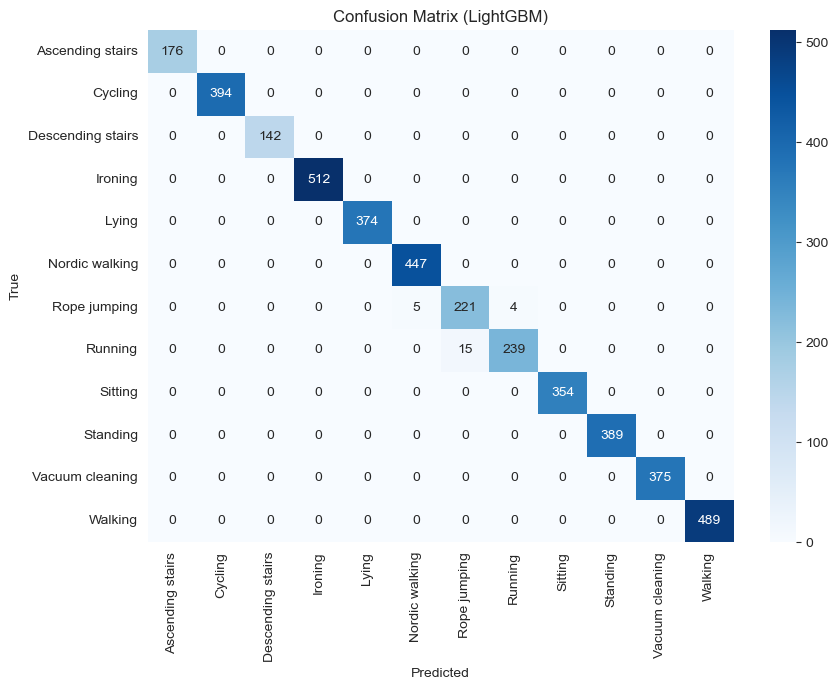

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = lgb_model.predict(X_test_ml)

cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix (LightGBM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
#Accuracy & Macro-F1 Bar Chart

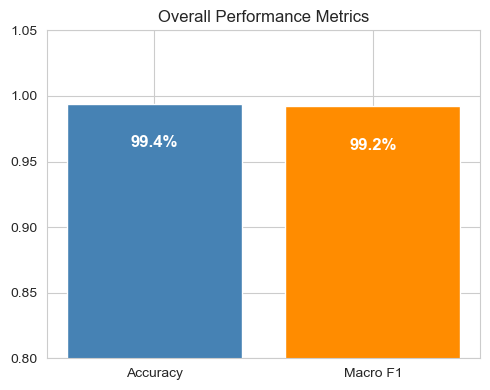

In [90]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

acc = accuracy_score(y_test_enc, y_pred)
f1  = f1_score(y_test_enc, y_pred, average="macro")

labels = ["Accuracy", "Macro F1"]
values = [acc, f1]

plt.figure(figsize=(5, 4))
bars = plt.bar(labels, values, color=["steelblue", "darkorange"])

plt.ylim(0.8, 1.05)
plt.title("Overall Performance Metrics")

# ---- ADD TEXT INSIDE BARS ----
for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val - 0.03,                     # position inside bar
        f"{val*100:.1f}%",
        ha="center",
        va="center",
        color="white",
        fontsize=12,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


In [ ]:
#Per-Class F1 Score

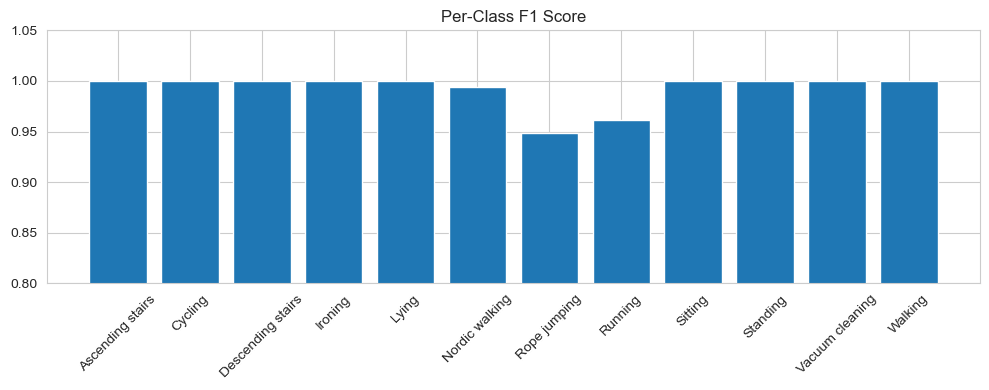

In [83]:
from sklearn.metrics import f1_score

f1_per_class = f1_score(y_test_enc, y_pred, average=None)

plt.figure(figsize=(10,4))
plt.bar(le.classes_, f1_per_class)
plt.xticks(rotation=45)
plt.ylim(0.8, 1.05)
plt.title("Per-Class F1 Score")
plt.tight_layout()
plt.show()


In [ ]:
#Training vs Validation Loss

In [88]:
evals_result = {}

lgb_model.fit(
    X_train_ml,
    y_train_enc,
    eval_set=[(X_train_ml, y_train_enc), (X_val_ml, y_val_enc)],
    eval_metric="multi_logloss",
    eval_names=["train", "val"],
    callbacks=[
        lgb.record_evaluation(evals_result)
    ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79893
[LightGBM] [Info] Number of data points in the train set: 18361, number of used features: 325
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(class_weight={np.int64(0): 1.360074074074074,
                             np.int64(1): 1.0317487075747358,
                             np.int64(2): 1.4076203618521925,
                             np.int64(3): 0.7129931655793724,
                             np.int64(4): 0.8275193798449613,
                             np.int64(5): 0.9533229491173416,
                             np.int64(6): 2.9595422308188266,
                             np.int64(7): 1.8000980392156862,
                             np.int64(8): 0.7794617082696553,
                             np.int64(9): 0.863965744400527,
                             np.int64(10): 0.9140282755874154,
                             np.int64(11): 0.667867015859159},
               colsample_bytree=0.9, learning_rate=0.03, n_estimators=1200,
               n_jobs=-1, num_class=12, num_leaves=128, objective='multiclass',
               random_state=42, subsample=0.9)

In [ ]:
#Plot Training vs Validation Loss

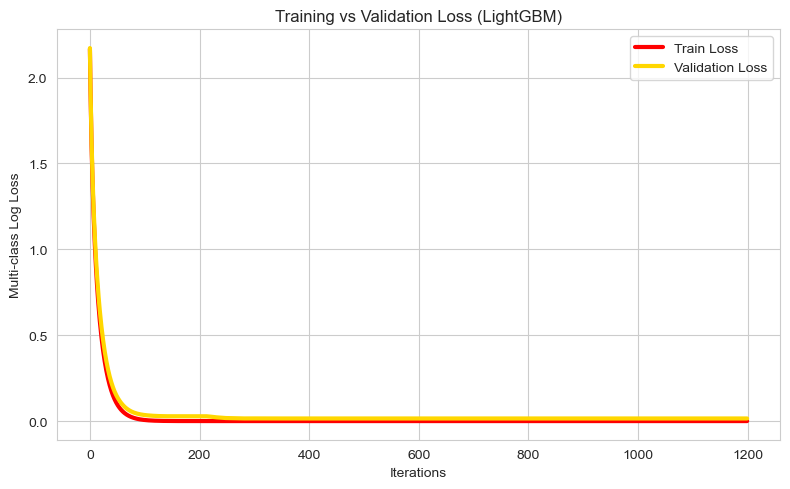

In [89]:
import matplotlib.pyplot as plt

train_loss = evals_result["train"]["multi_logloss"]
val_loss   = evals_result["val"]["multi_logloss"]

plt.figure(figsize=(8, 5))

plt.plot(
    train_loss,
    label="Train Loss",
    color="red",
    linewidth=3
)

plt.plot(
    val_loss,
    label="Validation Loss",
    color="gold",
    linewidth=3
)

plt.xlabel("Iterations")
plt.ylabel("Multi-class Log Loss")
plt.title("Training vs Validation Loss (LightGBM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Feature Importance

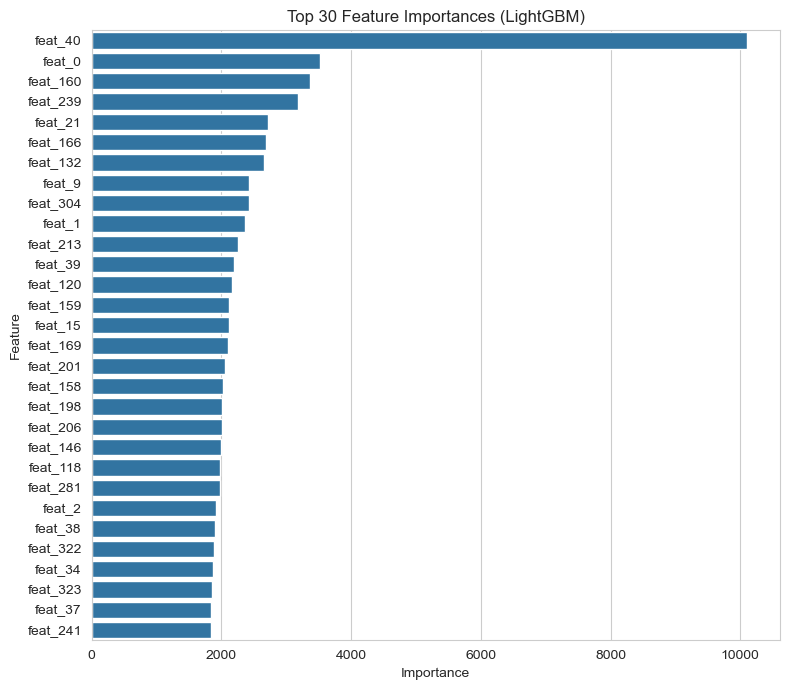

In [85]:
import pandas as pd

importances = lgb_model.feature_importances_
feat_names = [f"feat_{i}" for i in range(len(importances))]

fi = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(30)

plt.figure(figsize=(8,7))
sns.barplot(x="Importance", y="Feature", data=fi)
plt.title("Top 30 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()


In [ ]:
# Deep Feature Learning + LightGBM Hybrid Model

In [ ]:
# CNN Model

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU,
    MaxPooling1D, GlobalAveragePooling1D, Dropout
)

def build_cnn_feature_extractor(input_shape):
    inp = Input(shape=input_shape)

    x = Conv1D(64, 7, padding="same")(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, 5, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)

    return Model(inp, x, name="CNN_Feature_Extractor")


In [ ]:
# Train CNN Feature Extractor

In [116]:
cnn_feature_model = build_cnn_feature_extractor(
    input_shape=X_train.shape[1:]
)

cnn_feature_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse"
)

cnn_feature_model.summary()


Model: "CNN_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 41)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 256, 64)        │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 128, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,872 (624.50 KB)

 Trainable params: 158,976 (621.00 KB)

 Non-trainable params: 896 (3.50 KB)

In [129]:
def add_noise_batch(X, std=0.03):
    return X + np.random.normal(0, std, X.shape)

X_train_noisy = add_noise_batch(X_train, std=0.03)

cnn_model.fit(
    X_train_noisy, y_train_enc,
    validation_data=(X_val, y_val_enc),
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/60
574/574 ━━━━━━━━━━━━━━━━━━━━ 80s 137ms/step - accuracy: 0.9973 - loss: 0.0088 - val_accuracy: 0.9614 - val_loss: 0.1735 - learning_rate: 2.7000e-05
Epoch 2/60
574/574 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.9987 - loss: 0.0041 - val_accuracy: 0.9630 - val_loss: 0.1656 - learning_rate: 2.7000e-05
Epoch 3/60
574/574 ━━━━━━━━━━━━━━━━━━━━ 79s 138ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9632 - val_loss: 0.1667 - learning_rate: 2.7000e-05
Epoch 4/60
574/574 ━━━━━━━━━━━━━━━━━━━━ 77s 134ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9591 - val_loss: 0.1761 - learning_rate: 2.7000e-05
Epoch 5/60
574/574 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9564 - val_loss: 0.1822 - learning_rate: 2.7000e-05
Epoch 6/60
574/574 ━━━━━━━━━━━━━━━━━━━━ 80s 140ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9559 - val_loss: 0.1838 - learning_rate: 2.7000e-05
Epoch 7/60
574/574 ━━━━━━━━━━━━━━━━━━━━ 84s 14

In [117]:
# Extract Deep Features

In [118]:
X_train_cnn = cnn_feature_model.predict(X_train, batch_size=128)
X_val_cnn   = cnn_feature_model.predict(X_val, batch_size=128)
X_test_cnn  = cnn_feature_model.predict(X_test, batch_size=128)

print("CNN Feature Shapes:")
print(X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
CNN Feature Shapes:
(18361, 256) (7438, 256) (4136, 256)


In [ ]:
# Feature Fusion (CNN + Statistical Features)

In [119]:
import numpy as np

X_train_hybrid = np.hstack([X_train_feat, X_train_cnn])
X_val_hybrid   = np.hstack([X_val_feat, X_val_cnn])
X_test_hybrid  = np.hstack([X_test_feat, X_test_cnn])

print("Hybrid Feature Shape:", X_train_hybrid.shape)


Hybrid Feature Shape: (18361, 581)


In [ ]:
# LightGBM Hybrid Classifier

In [120]:
import lightgbm as lgb

lgb_hybrid = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(le.classes_),
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=128,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

lgb_hybrid.fit(
    X_train_hybrid,
    y_train_enc,
    eval_set=[(X_val_hybrid, y_val_enc)],
    eval_metric="multi_logloss"
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139793
[LightGBM] [Info] Number of data points in the train set: 18361, number of used features: 570
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Warning] No further splits with positive gain, b

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.03, n_estimators=1200, n_jobs=-1, num_class=12,
               num_leaves=128, objective='multiclass', random_state=42,
               subsample=0.8)

In [ ]:
# Hybrid Model Evaluation

In [121]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred_hybrid = lgb_hybrid.predict(X_test_hybrid)

acc_hybrid = accuracy_score(y_test_enc, y_pred_hybrid)
f1_hybrid  = f1_score(y_test_enc, y_pred_hybrid, average="macro")

print("Hybrid Test Accuracy :", acc_hybrid)
print("Hybrid Macro F1      :", f1_hybrid)

print("\nClassification Report:")
print(classification_report(
    y_test_enc,
    y_pred_hybrid,
    target_names=le.classes_
))


C:\Users\souga\anaconda3\envs\har-ml-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Hybrid Test Accuracy : 0.9927466150870407
Hybrid Macro F1      : 0.9909846666489771

Classification Report:
                   precision    recall  f1-score   support

 Ascending stairs       1.00      1.00      1.00       176
          Cycling       1.00      1.00      1.00       394
Descending stairs       1.00      1.00      1.00       142
          Ironing       1.00      1.00      1.00       512
            Lying       0.98      0.99      0.98       374
   Nordic walking       0.98      1.00      0.99       447
     Rope jumping       1.00      0.89      0.94       230
          Running       0.97      0.99      0.98       254
          Sitting       1.00      1.00      1.00       354
         Standing       1.00      1.00      1.00       389
  Vacuum cleaning       1.00      1.00      1.00       375
          Walking       1.00      1.00      1.00       489

         accuracy                           0.99      4136
        macro avg       0.99      0.99      0.99      4136
     

In [ ]:
# Accuracy & Macro-F1 (Hybrid)

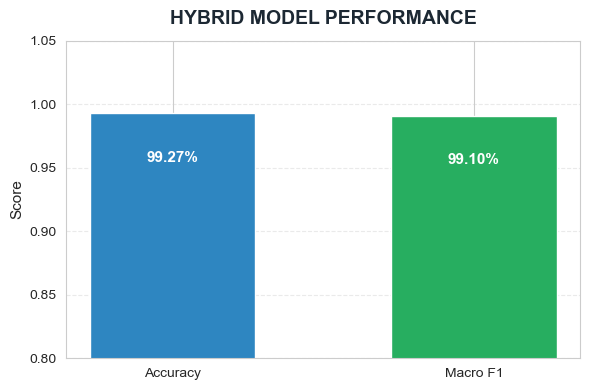

In [130]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Macro F1"]
values  = [acc_hybrid, f1_hybrid]
colors  = ["#2E86C1", "#27AE60"]  # Blue & Green

plt.figure(figsize=(6, 4))

bars = plt.bar(metrics, values, color=colors, width=0.55)

# Y-axis formatting
plt.ylim(0.8, 1.05)
plt.ylabel("Score", fontsize=11)

# Highlighted title
plt.title(
    "HYBRID MODEL PERFORMANCE",
    fontsize=14,
    fontweight="bold",
    color="#1C2833",
    pad=12
)

# Add value labels inside bars
for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val - 0.035,
        f"{val*100:.2f}%",
        ha="center",
        va="center",
        fontsize=11,
        fontweight="bold",
        color="white"
    )

# Grid & style
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# Confusion Matrix (Hybrid)

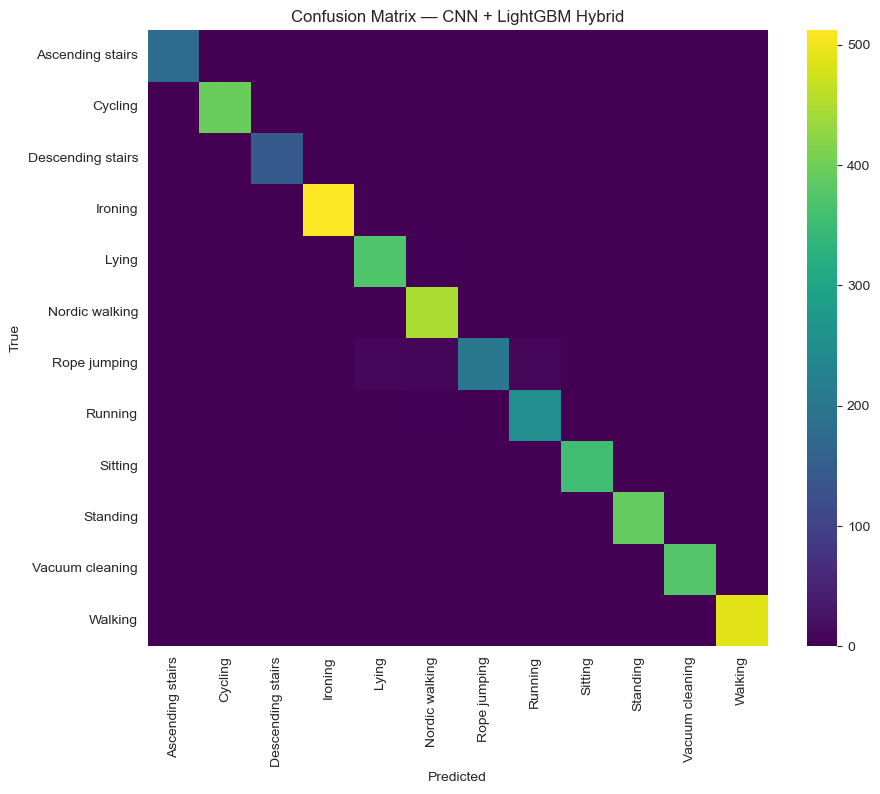

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_enc, y_pred_hybrid)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="viridis", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix — CNN + LightGBM Hybrid")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Training vs Validation Accuracy

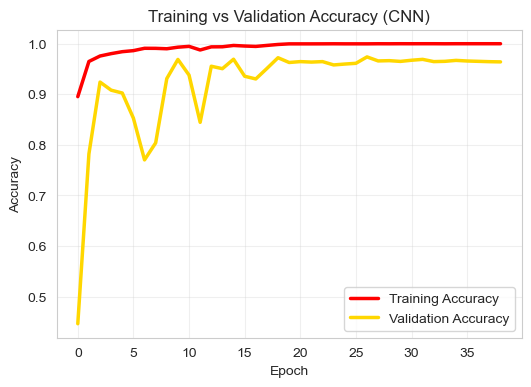

In [126]:
plt.figure(figsize=(6,4))

plt.plot(
    history.history["accuracy"],
    label="Training Accuracy",
    color="red",
    linewidth=2.5
)

plt.plot(
    history.history["val_accuracy"],
    label="Validation Accuracy",
    color="gold",
    linewidth=2.5
)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (CNN)")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [ ]:
# Training vs Validation Loss

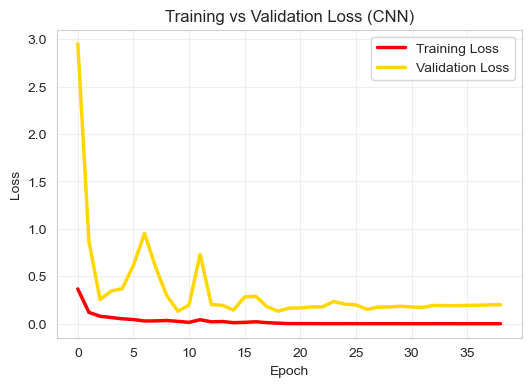

In [127]:
# Training vs Validation Loss

plt.figure(figsize=(6,4))

plt.plot(
    history.history["loss"],
    label="Training Loss",
    color="red",
    linewidth=2.5
)

plt.plot(
    history.history["val_loss"],
    label="Validation Loss",
    color="gold",
    linewidth=2.5
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (CNN)")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [ ]:
# Per-Class F1

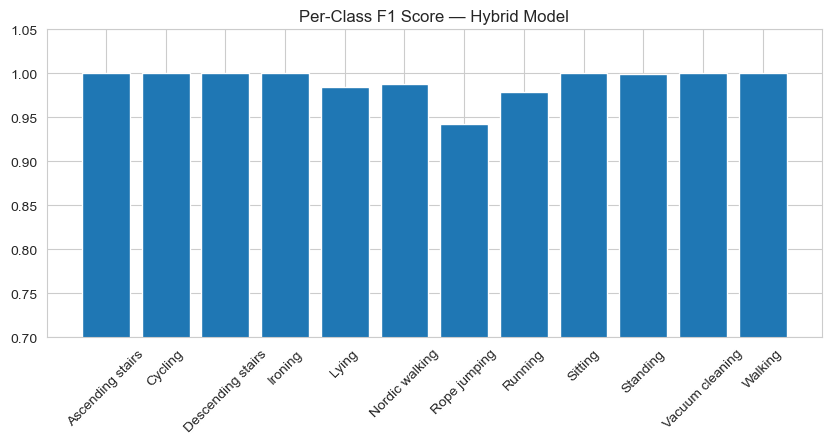

In [124]:
from sklearn.metrics import f1_score

f1_per_class = f1_score(y_test_enc, y_pred_hybrid, average=None)

plt.figure(figsize=(10,4))
plt.bar(le.classes_, f1_per_class)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.05)
plt.title("Per-Class F1 Score — Hybrid Model")
plt.show()


In [ ]:
# Feature Importance (Hybrid)

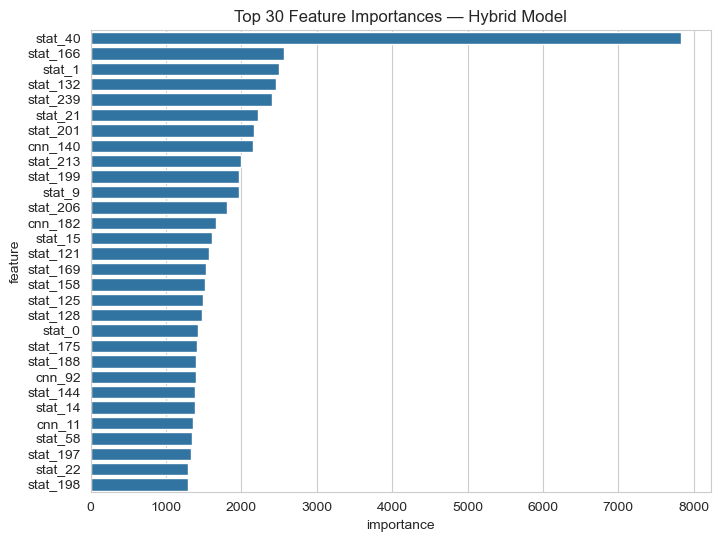

In [125]:
import pandas as pd

importance = lgb_hybrid.feature_importances_

feat_names = (
    [f"stat_{i}" for i in range(X_train_feat.shape[1])] +
    [f"cnn_{i}" for i in range(X_train_cnn.shape[1])]
)

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importance
}).sort_values("importance", ascending=False).head(30)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=imp_df)
plt.title("Top 30 Feature Importances — Hybrid Model")
plt.show()


In [ ]:
# Feature Importance (Hybrid LightGBM)

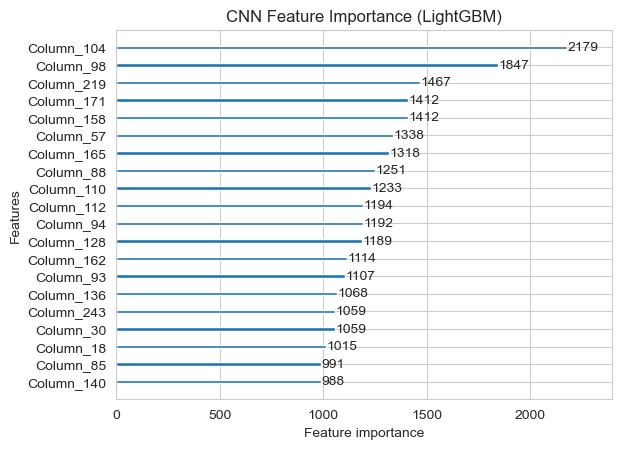

In [135]:
lgb.plot_importance(lgb_cnn, max_num_features=20)
plt.title("CNN Feature Importance (LightGBM)")
plt.show()


In [ ]:
# inal Comparison Table 

In [138]:
import pandas as pd

final_results_df = pd.DataFrame({
    "Model": [
        "LightGBM (Engineered Features)",
        "Hybrid CNN → LightGBM"
    ],
    "Test Accuracy (%)": [
        99.41,
        99.27
    ],
    "Macro F1 (%)": [
        99.20,
        99.09
    ]
})

final_results_df


Model  Test Accuracy (%)  Macro F1 (%)
0  LightGBM (Engineered Features)              99.41         99.20
1           Hybrid CNN → LightGBM              99.27         99.09

In [ ]:
# Graph

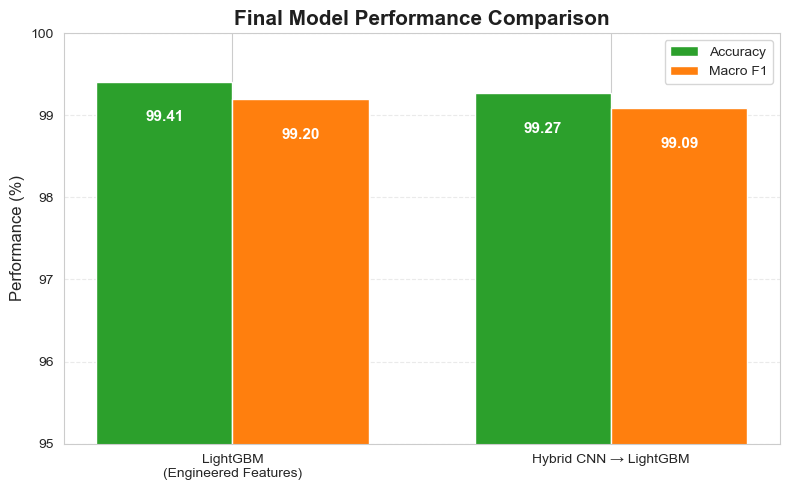

In [139]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    "LightGBM\n(Engineered Features)",
    "Hybrid CNN → LightGBM"
]

accuracy = [99.41, 99.27]
macro_f1 = [99.20, 99.09]

x = np.arange(len(models))
width = 0.36

plt.figure(figsize=(8, 5))

bars1 = plt.bar(
    x - width/2,
    accuracy,
    width,
    label="Accuracy",
    color="#2ca02c"
)

bars2 = plt.bar(
    x + width/2,
    macro_f1,
    width,
    label="Macro F1",
    color="#ff7f0e"
)

# Value labels inside bars
for bar in bars1 + bars2:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h - 0.35,
        f"{h:.2f}",
        ha="center",
        va="top",
        fontsize=11,
        fontweight="bold",
        color="white"
    )

plt.ylim(95, 100)
plt.ylabel("Performance (%)", fontsize=12)
plt.xticks(x, models)
plt.title(
    "Final Model Performance Comparison",
    fontsize=15,
    fontweight="bold",
    color="#1f1f1f"
)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# Radar Chart

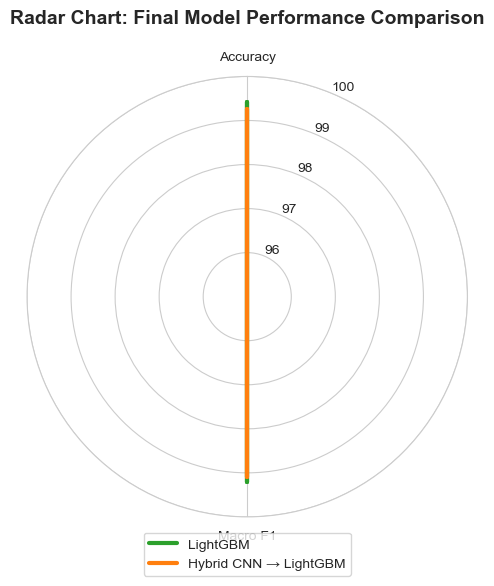

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics
labels = ["Accuracy", "Macro F1"]
num_vars = len(labels)

# Values (exact as requested)
lightgbm = [99.41, 99.20]
hybrid   = [99.27, 99.09]

# Close the radar loop
lightgbm += lightgbm[:1]
hybrid   += hybrid[:1]

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# LightGBM
ax.plot(angles, lightgbm, color="#2ca02c", linewidth=3, label="LightGBM")
ax.fill(angles, lightgbm, color="#2ca02c", alpha=0.25)

# Hybrid
ax.plot(angles, hybrid, color="#ff7f0e", linewidth=3, label="Hybrid CNN → LightGBM")
ax.fill(angles, hybrid, color="#ff7f0e", alpha=0.25)

# Axis & labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

ax.set_ylim(95, 100)
ax.set_yticks([96, 97, 98, 99, 100])
ax.set_yticklabels(["96", "97", "98", "99", "100"])

# Title & legend
plt.title(
    "Radar Chart: Final Model Performance Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=1)

plt.tight_layout()
plt.show()
